In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')
import pandas as pd
from plot import *
from analyze import *

/tmp/ipykernel_1255965/645144142.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [7]:
def postprocess_df(series, exclude_keys=None):
    """
    Takes a pandas Series with a MultiIndex and folds over all keys except for those specified
    in `exclude_keys` by concatenating the key name and its value into the 'algo' column values.

    Parameters:
    - series: pandas.Series with a MultiIndex.
    - exclude_keys: list of strings representing keys to exclude from the folding process.

    Returns:
    - A DataFrame with 'algo' and 'dataset' columns, where 'algo' has been modified to include
      information from other keys.
    """

    if exclude_keys is None:
      exclude_keys=['algo', 'dataset', 'final_acc']
    # Convert the Series into a DataFrame
    df = series.reset_index()
    
    # # Initialize a column to store the modified algo values
    df['modified_algo'] = df['algo']
    exclude_keys += ['modified_algo']
    
    # # Iterate over each level of the original MultiIndex (now columns in df)
    for key in df.columns:
        if key not in exclude_keys:
            # Append the key name and its value to the 'modified_algo' entries
            df['modified_algo'] = df['modified_algo'] + '_' + key + ':' + df[key].astype(str)
    
    # # Select and rename the relevant columns for the final DataFrame
    final_df = df[['modified_algo', 'dataset', series.name]].copy()
    final_df.rename(columns={'modified_algo': 'algo', series.name: 'value'}, inplace=True)
    
    return final_df

def aggregate_results(df, keys=None, metric=None, post_process=True,
                      error_type="sem"):
   if keys is None:
      keys = ["algo", "use_contrastive"]
   if metric is None:
      metric = "final_acc"
   keys += ["dataset"]
   m = df.groupby(keys)[
         metric].mean()
   if error_type == "sem":
      stderr = df.groupby(keys)[metric].sem()
   else:
      stderr = df.groupby(keys)[metric].std()
   if post_process:
      exclude_keys=["algo", "dataset", metric]
      m = postprocess_df(m, exclude_keys)
      stderr = postprocess_df(stderr, exclude_keys)
   return m, stderr

In [8]:
keys=None
error_type="sem"
metric="auc"

In [9]:
df = pd.read_csv('cluster_results/combine_modes_results.csv')
m, stderr = aggregate_results(df, keys=keys, metric=metric,
                                  error_type=error_type)

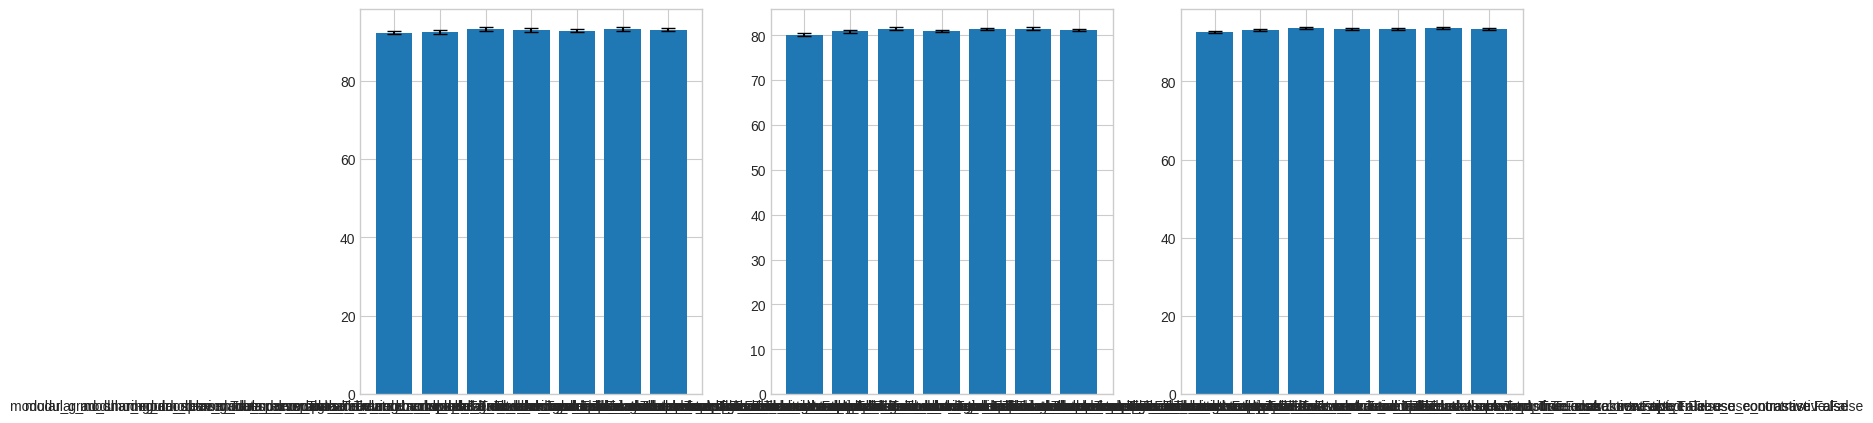

In [20]:
datasets = m['dataset'].unique()

fig, ax = plt.subplots(1, len(datasets), figsize=(15, 5))


for i, dataset in enumerate(datasets):
    m_d = m[m['dataset'] == dataset]
    err_d = stderr[stderr['dataset'] == dataset]
    ax[i].bar(m_d['algo'], m_d['value'], yerr=err_d['value'], capsize=5)

In [21]:
m_d

,algo,dataset,value
2,modular_grad_sharing_no_sparse_True_recv_mod_a...,mnist,92.681668
5,modular_modmod+grad_sharing_no_sparse_True_rec...,mnist,93.066092
8,modular_modmod+recv_data_no_sparse_True_recv_m...,mnist,93.597427
11,modular_modmod_no_sparse_True_recv_mod_add_dat...,mnist,93.351192
14,modular_recv_data+modmod+grad_sharing_no_spars...,mnist,93.352759
17,modular_recv_data+modmod_no_sparse_True_recv_m...,mnist,93.597427
20,modular_recv_data_no_sparse_True_recv_mod_add_...,mnist,93.369229


In [22]:
dataset

'mnist'